In [1]:
import os,sys, h5py, pdb,time, glob
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log, log as ln
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = wd.basedir + '/../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [4]:
simnames = ['vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking',
            'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3']
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc%d_fgas02_res1e4_vturb%d'
vc = 200. *un.km/un.s 
Rcirc = 1.*un.kpc
for isim in range(1,4):
    for ivt,vturb in enumerate((3,30,100)):
        if isim==0: Rsonic,Mdot = 0,   226
        if isim==1: Rsonic,Mdot = 0.05,1212
        if isim==2: Rsonic,Mdot = 3,   3668
        if isim==3: Rsonic,Mdot = 20,  4536        
        simnames.append( simname_template%(Rsonic,Mdot,Rcirc.value,vturb))    

In [5]:
simname = 'vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3'
#simname = 'vc200_Rs0_Mdot2069_Rcirc15_fgas02_res1e3'
rmax = 40
track_length = 2250
dt = snapshot_dt_Myr = 50
Rcirc = 15*un.kpc
vc = 200*un.km/un.s
simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,
               pr=False,analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
sim.z = 0 #for cooling function

In [6]:
simnames.append(simname)

In [7]:
theta_midbins = np.array([0.1,0.2,0.3,0.45])*np.pi; l = len(theta_midbins)
dtheta = 0.025*np.pi

colors = pl.get_cmap('viridis')(1-np.arange(l)/(l-1))
labels_short = [(r'$%.'+'%d'%(1,2)[im==3]+'f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]
labels = [(r'$\theta_0=%.'+'%d'%(1,2)[im==3]+'f\pi$')%m for im,m in enumerate(theta_midbins/np.pi)]

def med_and_std(all_vals,xs,theta_inds,tSF,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        vals = all_vals[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        pl.plot(xs[goods]/1000,ys50[goods],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[goods]/1000,ys16[goods],ys84[goods],facecolor=colors[i],alpha=0.1)    

In [8]:
def shift_arr(arr,t_offset_ind,actual_Nsnapshots,time_after_105):
    shifted_arr = np.zeros(arr.shape)
    for i in range(arr.shape[1]):
        shifted_arr[:,i] = np.roll(arr[:,i],-t_offset_ind[i])
        shifted_arr[actual_Nsnapshots-t_offset_ind[i]:actual_Nsnapshots-time_after_105,i] = np.nan
    return np.roll(shifted_arr, time_after_105,axis=0)
def med_and_std_shift(all_vals,xs,theta_inds,t105_ind,actual_Nsnapshots,time_after_105, show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        _vals = all_vals[:,theta_inds[i] & (t105_ind!=0)]
        vals = shift_arr(_vals,t105_ind[theta_inds[i] & (t105_ind!=0)],actual_Nsnapshots,time_after_105)
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,ys50[inds],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    
def relative_dispersion_shift(all_vals,xs,theta_inds,t105_ind,actual_Nsnapshots,time_after_105):
    for i,ind in enumerate(theta_midbins):        
        _vals = all_vals[:,theta_inds[i] & (t105_ind!=0)]
        vals = shift_arr(_vals,t105_ind[theta_inds[i] & (t105_ind!=0)],actual_Nsnapshots,time_after_105)
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,(ys84-ys16)[inds]/2/ys50[inds],label=labels[i],c=colors[i])

In [40]:
dphis_arr = {}; Ts_arr = {}; nHs_arr = {}; nHsdisp = {}; nHsdisp_inds = {}; ts_offset = {}; rs_arr = {}
dphis_arr_shift = {}; Ts_arr_shift = {}; nHs_arr_shift = {}; nHsdisp_shift = {}; nHsdisp_inds_shift = {}; 
ts_norm = {}; theta_inds_arr = {}; t105_ind_arr = {}
for isim,simname in enumerate(simnames):
    #if isim not in (0,2,5): continue
    if simname.split('_')[-1][:5]=='vturb':
        if len(simname.split('_')[-1])!=6: continue

    vc = 200. *un.km/un.s
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    dt = (10,50)[isim>=7]    
    rmax = (40,30)[isim>=1 and isim<=9]
    Nsnapshots = (225,400)[isim>=1 and isim<=9]
    actual_Nsnapshots = Nsnapshots // (dt//10)
    time_after_105 = 25 //(dt//10) 
    ts = -np.arange(actual_Nsnapshots)*dt
    ts = ts-ts[-1]
    ts_norm[simname] = ts
    ts_offset[simname] = -np.arange(-time_after_105*dt,(actual_Nsnapshots-time_after_105)*dt,dt)
    npz_fn = wd.tracksdir+simname+'/particle_tracks_%d_%d_%d_all.npz'%((Nsnapshots,actual_Nsnapshots)[isim==16],dt,rmax)
    if not os.path.exists(npz_fn): continue
    f = np.load(npz_fn)
    coords,vs,Ts,nHs,tcools=f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools']
    isStar = np.isnan(Ts[:,:])
    isCool = isStar + (Ts[:,:]<1e5)
    t105_ind = np.array([np.concatenate([np.array([True]), isCool[:,i]]).nonzero()[0][-1] for i in range(isCool.shape[1])])
    t105_ind_arr[simname] = t105_ind
    print(simname, ff.u.mifkad(t105_ind==0))
#     t105= ts[t105_ind]
    xs,ys,zs = coords[:,:,0],coords[:,:,1],coords[:,:,2]
    rs    = (xs**2+ys**2+zs**2)**0.5
    Rs    = (xs**2+ys**2)**0.5
    thetas = np.arccos(zs/rs)
    theta_inds = np.zeros((len(theta_midbins),thetas.shape[1]))
    for itheta,theta_midbin in enumerate(theta_midbins):
        theta_infty = np.median(thetas[-10:,:],axis=0)
        theta_inds[itheta,:] = (theta_infty<theta_midbin+dtheta) & (theta_infty>theta_midbin-dtheta)
    theta_inds = theta_inds.astype('bool')
    theta_inds_arr[simname] = theta_inds
    phis  = np.arctan2(ys,xs)
    dphis = ((phis[:-1,:]-phis[1:,:])%(2*np.pi))[::-1].cumsum(axis=0)[::-1]    
    dphis_arr[simname] = dphis = np.pad(dphis,((0,1),(0,0)),mode='constant')
    Ts_arr[simname] = Ts
    nHs_arr[simname] = nHs
    rs_arr[simname] = rs

    dphis_arr_shift[simname] = shift_arr(dphis[:,t105_ind!=0],t105_ind[t105_ind!=0],actual_Nsnapshots,time_after_105)
    #Ts_arr_shift[simname]    = shift_arr(Ts[:,t105_ind!=0],   t105_ind[t105_ind!=0],actual_Nsnapshots,time_after_105)
    #nHs_arr_shift[simname]   = shift_arr(nHs[:,t105_ind!=0],  t105_ind[t105_ind!=0],actual_Nsnapshots,time_after_105)
    #ys16,ys50,ys84 = [np.nanpercentile(nHs_arr[simname],p,axis=1) for p in (16,50,84)]
    #inds = nHsdisp_inds_shift[simname] = ys16>0
    #nHsdisp_shift[simname] = (ys84-ys16)[inds]/2/ys50[inds]


vc200_Rs0_Mdot4847_Rcirc10_fgas02_res1e4_n10_NoLowCool_tracking {False: 170096, True: 12}
vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 {False: 113592}
vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 {False: 95804}
vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb3 {False: 11892}
vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3 {False: 100615}


/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/li

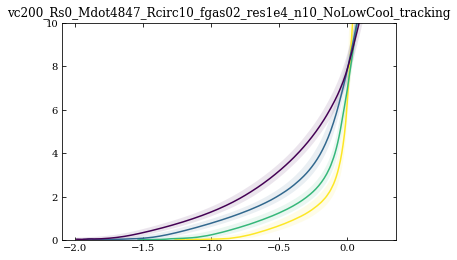

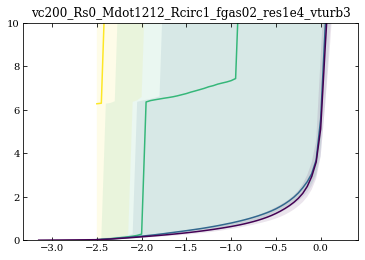

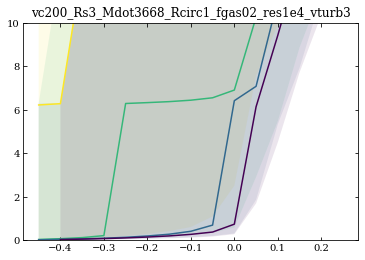

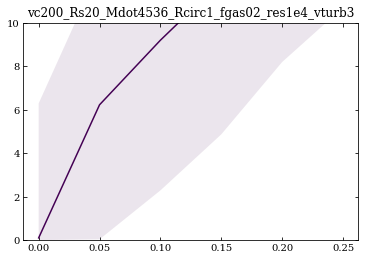

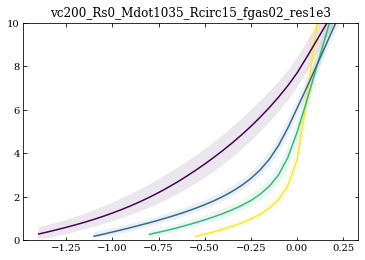

In [41]:
for isim,simname in enumerate(simnames):
    #if isim not in (0,2,5): continue
    vc = 200. *un.km/un.s
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    dt = (10,50)[isim>=7]    
    rmax = (40,30)[isim>=1 and isim<=9]
    Nsnapshots = (225,400)[isim>=1 and isim<=9]
    actual_Nsnapshots = Nsnapshots // (dt//10)
    time_after_105 = 25 //(dt//10) 
    ts = -np.arange(actual_Nsnapshots)*dt

    if simname in dphis_arr:
        pl.figure()    
        pl.title(simname)
        med_and_std_shift(dphis_arr[simname],ts_offset[simname],theta_inds_arr[simname],t105_ind_arr[simname],
                          actual_Nsnapshots,time_after_105)
        pl.ylim(0,10)

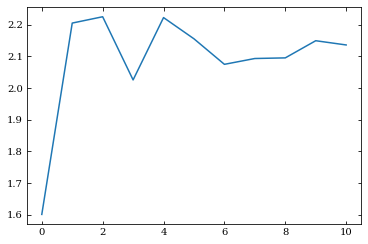

In [31]:
res = []
for isim,simname in enumerate(simnames):
    if simname in dphis_arr:
        Nparticles = len(t105_ind_arr[simname])
        indices = np.array([np.arange(Nparticles),t105_ind_arr[simname]]).T
        goods = t105_ind_arr[simname]!=0
        Nrots = dphis_arr[simname].take(indices)[goods]
        res.append((log(Nrots).mean(), Nrots.std()))
        
pl.plot([x[0] for x in res])


In [25]:
dphis_arr[simname].shape

(225, 170108)

In [22]:
list(dphis_arr.values())[-1].shape

(45, 36245)

/tmp/ipykernel_523960/3210225321.py:7: RuntimeWarning: Mean of empty slice
  pl.plot(xs,np.nanmean(Ts_arr_shift[simname],axis=1),label=simname.split('_')[-1])
/tmp/ipykernel_523960/3210225321.py:9: RuntimeWarning: Mean of empty slice
  ys = np.nanmean(dphis_arr_shift[simname],axis=1)


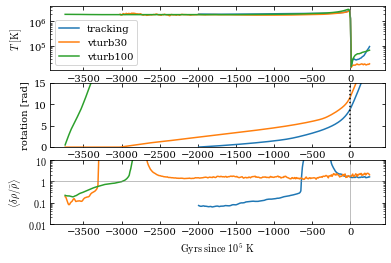

In [20]:
for iPanel in range(3):
    ax = pl.subplot(3,1,iPanel+1)
    for isim,simname in enumerate(simnames):
        if isim not in (0,2,5): continue
        xs = ts_offset[simname]
        if iPanel==0:
            pl.plot(xs,np.nanmean(Ts_arr_shift[simname],axis=1),label=simname.split('_')[-1])
        if iPanel==1:
            ys = np.nanmean(dphis_arr_shift[simname],axis=1)
            pl.plot(xs,np.nancumsum(ys[::-1])[::-1])
        if iPanel==2:
            pl.plot(xs[nHsdisp_inds_shift[simname]],nHsdisp_shift[simname])
    pl.xlabel(r'${\rm Gyrs}\ {\rm since}\ 10^5\ {\rm K}$')
    pl.axvline(0,c='.5',lw=0.5)
    if iPanel==0:
        pl.semilogy() 
        pl.ylabel(r'$T\ [{\rm K}]$')
        pl.legend()
    if iPanel==1:
        pl.axvline(0,c='k',ls=':')
        pl.ylabel('rotation [rad]')
        pl.ylim(0,15)
    if iPanel==2:
        pl.semilogy()
        pl.ylabel(r'$\langle\delta \rho/\bar \rho\rangle$')
        ax.yaxis.set_major_formatter(u.arilogformatter)
        pl.ylim(0.01,10)
        pl.axhline(1,c='.5',lw=0.5)
#     totalPhis[simname] = (dphis*(1-isCool)*(1-isStar)).sum(axis=0)

In [ ]:
for iPanel in range(3):
    ax = pl.subplot(3,1,iPanel+1)
    for isim,simname in enumerate(simnames):
        if isim not in (0,2,5): continue
        xs = ts_norm[simname]
        if iPanel==0:
            pl.plot(xs,np.nanmean(Ts_arr[simname],axis=1),label=simname.split('_')[-1])
        if iPanel==1:
            ys = np.nanmean(dphis_arr[simname],axis=1)
            pl.plot(xs,np.nancumsum(ys[::-1])[::-1])
        if iPanel==2:
            pl.plot(xs,np.nanmean(rs_arr[simname],axis=1))
        if iPanel==3:
            pl.plot(xs[nHsdisp_inds[simname]],nHsdisp[simname])
    pl.xlabel(r'${\rm Gyrs}\ {\rm since}\ 30\,{\rm kpc}$')
    pl.axvline(0,c='.5',lw=0.5)
    if iPanel==0:
        pl.semilogy() 
        pl.ylabel(r'$T\ [{\rm K}]$')
        pl.legend()
    if iPanel==1:
        pl.axvline(0,c='k',ls=':')
        pl.ylabel('rotation [rad]')
        pl.ylim(0,15)
    if iPanel==3:
        pl.semilogy()
        pl.ylabel(r'$\langle\delta \rho/\bar \rho\rangle$')
        ax.yaxis.set_major_formatter(u.arilogformatter)
        pl.ylim(0.01,10)
        pl.axhline(1,c='.5',lw=0.5)
#     totalPhis[simname] = (dphis*(1-isCool)*(1-isStar)).sum(axis=0)

In [26]:
theta_midbins = np.array([0.1,0.2,0.3,0.45])*np.pi; l = len(theta_midbins)
dtheta = 0.025*np.pi
theta_inds = np.zeros((len(theta_midbins),thetas.shape[1]))
for itheta,theta_midbin in enumerate(theta_midbins):
    theta_infty = np.median(thetas[-10:,:],axis=0)
    theta_inds[itheta,:] = (theta_infty<theta_midbin+dtheta) & (theta_infty>theta_midbin-dtheta)
theta_inds = theta_inds.astype('bool')
print(theta_inds.sum(axis=1))

[ 846 1751 2326 2931]


[[<matplotlib.lines.Line2D at 0x1552f2663520>],

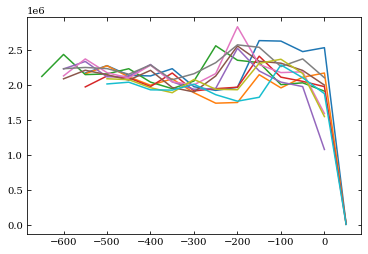

In [132]:
[pl.plot(ts_offset,shift_arr(Ts[:,i:i+1],  t105_ind[i:i+1],actual_Nsnapshots,time_after_105)) for i in range(10)]

In [16]:
def relative_dispersion_shift(all_vals,xs=ts_offset,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):        
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,(ys84-ys16)[inds]/2/ys50[inds],label=labels[i],c=colors[i])

NameError: name 'theta_inds' is not defined

In [17]:
def med_and_std_shift(all_vals,xs=ts_offset,theta_inds=theta_inds,show_std=True,ls='-'):
    for i,ind in enumerate(theta_midbins):
        _vals = all_vals[:,theta_inds[i]]
        vals = shift_arr(_vals,t105_ind[theta_inds[i]])
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        inds = ys16>0
        pl.plot(xs[inds]/1000,ys50[inds],label=labels[i],c=colors[i],ls=ls)
        if show_std: pl.fill_between(xs[inds]/1000,ys16[inds],ys84[inds],facecolor=colors[i],alpha=0.1)    


NameError: name 'theta_inds' is not defined

In [29]:
def med_and_std_dphi(dphis,xs=ts,theta_inds=theta_inds):
    for i,ind in enumerate(theta_midbins):
        vals = dphis[:,theta_inds[i]]
        ys16,ys50,ys84 = [np.nanpercentile(vals,p,axis=1) for p in (16,50,84)]
        goods = xs<np.median(tSF[theta_inds[i]])
        for j in np.arange(0,max(ys50[goods]/(2*np.pi))+1):
            goods2 = goods & (ys50//(2*np.pi) == j)
            pl.plot(xs[goods2]/1000,ys50[goods2]/(2*np.pi)%1,label=labels[i],c=colors[i])
            pl.fill_between(xs[goods2]/1000,ys16[goods2]/(2*np.pi)%1,ys84[goods2]/(2*np.pi)%1,facecolor=colors[i],alpha=0.1)            

TypeError: shift_arr() missing 2 required positional arguments: 'actual_Nsnapshots' and 'time_after_105'

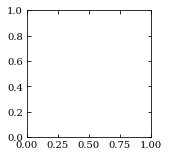

In [30]:
xls = -1.,0.35
pl.figure(figsize=(fig_width_full*1.1,5.5)); pl.subplots_adjust(hspace=0.35,wspace=0.25)
ax = pl.subplot(231)
med_and_std_shift(nHs)
pl.title(r'$n_{\rm H}\ [{\rm cm}^{-3}]$')
pl.legend(loc='upper left',ncol=1,frameon=False,labelspacing=0.2,handlelength=1,columnspacing=0.5,handletextpad=0.2)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(232)
med_and_std_shift(Ts)
pl.title(r'$T\ [{\rm K}]$')
pl.text(-0.5,4e6,r'hot CGM',ha='center')
pl.text(0.175,2e4,r'ISM',ha='center')
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(233)
med_and_std_shift(nHTs)
pl.title(r'$n_{\rm H} T\ [{\rm cm}^{-3}\ {\rm K}]$')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
pl.ylim(1e3,1e5)
ax.set_yscale('log'); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(234)
med_and_std_shift(Ks)
pl.title(r'$K\ [{\rm keV}\ {\rm cm}^2]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.ylim(0,30)
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(235)
relative_dispersion_shift(nHs)
pl.semilogy()
pl.title(r'$\langle\delta \rho/\bar \rho\rangle$')
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(0.01,10)
pl.axhline(1,c='.5',lw=0.5)
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.xlim(*xls)
pl.axvline(0,c='.5',lw=0.5)
ax = pl.subplot(236)
med_and_std_shift(jzs/1000)
pl.title(r'$j_z\ [10^3\ {\rm kpc}\ {\rm km}\ {\rm s}^{-1}]$')
pl.xlabel(r'${\rm time}\ {\rm since}\ 10^5\ {\rm K}\ [{\rm Gyr}]$')
pl.axvline(0,c='.5',lw=0.5)
pl.xlim(*xls)
pl.savefig(figdir+'tracking_properties_vs_t105.pdf',bbox_inches='tight')

In [57]:
for isim,simname in enumerate(simnames):
    if len(simname.split('_'))==7:
        vturb = float(simname.split('_')[6][5:])*un.km/un.s
    else: vturb = 1e-3*un.km/un.s #for color
    if vturb.value>3: continue

    if simname in totalPhis.keys():
        print(simname,totalPhis[simname].mean(),totalPhis[simname].std())

vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 34.137272320622415 45.84921788850131
vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 13.344675735110865 16.99716127692641
vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb3 2.282571273289917 3.632161149122476


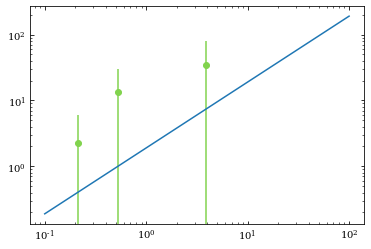

In [56]:
pl.figure()
for isim,simname in enumerate(simnames):
    if simname not in totalPhis.keys(): continue
    if len(simname.split('_'))==7:
        vturb = float(simname.split('_')[6][5:])*un.km/un.s
    else: vturb = 1e-3*un.km/un.s #for color
    if vturb.value>3: continue
    Rcirc = float(simname.split('_')[3][5:])*un.kpc                          
    Rsonic = float(simname.split('_')[1][2:])*un.kpc                          
    if Rsonic==0*un.kpc: Rsonic = 0.05*un.kpc
    t_ratio_at_Rcirc = (Rcirc/Rsonic)**0.5
    c = pl.get_cmap('viridis')(1-log(vturb.value)/2.5)
    marker = 'ox'[(Rcirc.value==10).astype(int)]
    pl.errorbar([t_ratio_at_Rcirc*10.**np.random.normal(0,0.05)],
               [totalPhis[simname].mean()],
               [totalPhis[simname].std()],
               color=c,marker=marker)
pl.loglog()
xs = np.array([0.1,100])
pl.plot(xs,1.9*xs)


0.19239644767571878